In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spl
from scipy.spatial.transform import Rotation
%matplotlib notebook

In [2]:
def checkTypes(phaseVec):
    if not isinstance(phaseVec, np.ndarray):
        print("The phase vector must be a numpy array.")
        return False
        return False
    if not phaseVec.shape[0] == 6:
        print("The phase vector must be a 6xN matrix, where N is the number of particles")
        return False
    return True

def newtonsForceLaw(phaseVec, GM=1): # takes in a phaseVec 6xN and outputs a force 3xN, m=1 always
    norms = np.linalg.norm(phaseVec[:3], axis = 0)
    return -phaseVec[:3]/np.power(norms, 3)

def turn(phaseVec, n=1, timestep=0.001):
    if not checkTypes(phaseVec):
        return
    newPhaseVec =  np.empty((6, phaseVec.shape[1]))
    force = newtonsForceLaw(phaseVec)
    
    newPhaseVec[:3] = phaseVec[:3] + timestep*phaseVec[3:]
    newPhaseVec[3:] = phaseVec[3:] + timestep*force
    return newPhaseVec

In [2]:
class OrbitType:
    NONE = 0
    CIRCLE = 1 # e = 0
    ELLIPS = 2 # 0 < e < 1
    LINEAR = 3 # e = 1 and |L| = 0
    PERABOLA = 4 # e = 1 and |L| > 0
    HYPER = 5 # 1 < e

def energyCart(phaseVec, GM=1):
    norms = np.linalg.norm(phaseVec[:3], axis = 0)
    return np.square(np.linalg.norm(phaseVec[3:], axis=0))/2 - GM/norms

def angular_momentum_norm_spherical(phaseVec):
    return np.sqrt(np.square(phaseVec[4]/phaseVec[0]) + np.square(phaseVec[5]/(phaseVec[0]*np.sin(phaseVec[1]))))
    
def energySph(phaseVec, GM=1):
    return np.square(phaseVec[3])/2 + np.square(angular_momentum_norm_spherical(phaseVec))/2 - GM/phaseVec[0]

def angular_momentum(phaseVec):
    return np.cross(phaseVec[:3], phaseVec[3:], axis=0)

def radius(phaseVec):
    return np.linalg.norm(phaseVec[:3], axis=0)

def spherical_angles(phaseVec):
    return np.arctan(phaseVec[1]/phaseVec[0]), np.arctan(phaseVec[2]/np.sqrt(np.square(phaseVec[1]) + np.square(phaseVec[0])))
    
class Orbit:
    orbit = OrbitType.NONE
    a = 0.0
    e = -1.0
    M_0 = 0.0
    theta_0 = 0.0
    Arg_Peri = 0.0
    Long_of_Ascend = 0.0
    
    def __init__(phaseVec, spherical=False, GM=1.0):
        if not isinstance(phaseVec, np.ndarray):
            raise ValueError("The phaseVec must be an instance np.ndarray, but is not.")
        if not phaseVec.shape == 6:
            raise ValueError("The phaseVec must be 6 dimentional not {} dimentional".format(phaseVec.shape))
            
        L = angular_momentum(phaseVec)
        L_2 = np.square(np.linalg.norm(L, axis=0))
        L_z = L[2]
        E = energyCart(phaseVec)
        
        print("L: ", L, "\t L^2 ", L_2, "\t L_z ", L_z, "\t E ", E)
        
        if L_2 == 0:
            # Linear Orbit
            self.orbit = OrbitType.LINEAR
            
            self.a = radius(phaseVec)
            theta, phi = spherical_angles(phaseVec)
            
            self.theta_0 = theta # this is just use as initial theta
            self.Arg_Peri = phi # this is just use as initial phi
            
            self.e = None
            self.M_0 = None
            self.theta_0 = None
            self.Long_of_Ascend = None
            
        elif E == 0:
            # Perobolic Trajectory
            self.orbit = OrbitType.PERABOLA
            
            self.a = L_2/GM
            self.e = 1.0
            
            f = np.arccos(self.a/radius(phaseVec) - 1)
            
            D = np.tan(f/2)
            
            self.M_0 = np.power(self.a, 3.0/2.0)/np.sqrt(GM)*(D + np.power(D, 3)/3)
            
            self.theta_0 = np.arcsin(L_z/np.sqrt(L_2))
            
            theta, phi = spherical_angles(phaseVec)
            
            if np.cos(theta_0) == 0:
                self.Arg_Peri = 
            else:
                self.Arg_Peri = -f+np.arcsin(np.cos(theta)/np.cos(theta_0))
            
        elif E > 0:
            # Hyperbolic Trajectory
            self.orbit = OrbitType.HYPER
            
            v_infity = np.sqrt(2E)
            
            a = -GM/np.square(v_infity)
            
        else:
            self.a = -1/(2*E)

            self.e = np.sqrt(1 - L_2/a)

            if 1 > self.e > 0:
                # Eliptic Orbit
                self.orbit = OrbitType.ELLIPS

                self.theta_0 = np.arcsin(L_z/np.sqrt(L_2))

                # Initial Action Perameters

                Ellistic_anomily = np.arccos((1 - radius(phaseVec)/a)/e)

                self.M_0 = Ellistic_anomily - self.e*np.sin(Ellistic_anomily)

                f = 2*np.arctan(np.sqrt((1 + self.e)/(1 - self.e)) * np.tan(Ellistic_anomily/2))

                theta, phi = spherical_angles(phaseVec)

                unit_theta = np.array([-np.sin(phi)*np.sin(theta), np.sin(phi)*np.cos(theta), np.cos(phi)])

                theta_sign = np.sign(np.einsum('ij,ij->j', phaseVec[3:], unit_theta))

                print("Theta_0: ", self.theta_0, "\t Actual Theta ", theta)

                self.Arg_Peri = -f + theta_sign*np.arcsin(np.cos(theta)/np.cos(self.theta_0))

                self.Long_of_Ascend = np.sign(L_z)*phi - theta_sign*np.arcsin(np.tan(self.theta_0)/np.cos(theta))

            elif self.e == 0:
                # Circuler Orbit
                self.orbit = OrbitType.CIRCLE

                theta, phi = spherical_angles(phaseVec)
                if L_z != 0.0:
                    self.M_0 = theta

                    self.theta_0 = np.arcsin(L_z/np.sqrt(L_2))

                    unit_theta = np.array([-np.sin(phi)*np.sin(theta), np.sin(phi)*np.cos(theta), np.cos(phi)])

                    theta_sign = np.sign(np.einsum('ij,ij->j', phaseVec[3:], unit_theta))

                    self.Arg_Peri = -theta + theta_sign*np.arcsin(np.cos(theta)/np.cos(self.theta_0))

                    self.Long_of_Ascend = np.sign(L_z)*phi - theta_sign*np.arcsin(np.tan(self.theta_0)/np.cos(theta))

                else:
                    self.M_0 = phi

                    self.theta_0 = 0.0

                    unit_theta = np.array([-np.sin(phi)*np.sin(theta), np.sin(phi)*np.cos(theta), np.cos(phi)])

                    self.Arg_Peri = -self.M_0

                    self.Long_of_Ascend = np.sign(L_z)*phi

    
    def position(time):
        return np.array([0,0,0,0,0,0])
    
    def position_spherical(time):
        return np.array([0,0,0,0,0,0])
    
    def __str__():
        return "Orbit={}, a={}, e={}, M_0={}, w={}, Omega={}".format(orbit, a, e, M_0, Arg_Peri, Long_of_Ascend)
    
    def __repl__():
        return "Orbit={}, a={}, e={}, M_0={}, w={}, Omega={}".format(orbit, a, e, M_0, Arg_Peri, Long_of_Ascend)
    
    
def findOribtalPerametersCartisian(phaseVec, GM = 1, time = 0):
    L = angular_momentum(phaseVec)
    L_2 = np.square(np.linalg.norm(L, axis=0))
    L_z = L[2]
    E = energyCart(phaseVec)
    
    print("L: ", L, "\t L^2 ", L_2, "\t L_z ", L_z, "\t E ", E)
    
    ORBIT_TYPE = E >= 1
    
    # Action Perameters
    
    a = -1/(2*E)
    
    e = np.sqrt(1 - L_2/a)
    
    theta_0 = np.empty(phaseVec.shape[0])
    M_0 = np.empty(phaseVec.shape[0])
    Arg_Peri = np.empty(phaseVec.shape[0])
    Long_of_Ascend = np.empty(phaseVec.shape[0])
    theta_sign = np.empty(phaseVec.shape[0])
    
    for i in range(0, phaseVec.shape[0]):
        
        if 1 > e[i] > 0:
            # Eliptic Orbit
            theta_0[i] = np.arcsin(L_z[i]/np.sqrt(L_2[i]))
    
            # Initial Action Perameters
    
            Ellistic_anomily = np.arccos((1 - radius(phaseVec[:][i])/a[i])/e[i])
    
            M_0[i] = Ellistic_anomily - e[i]*np.sin(Ellistic_anomily)
    
            f = 2*np.arctan(np.sqrt((1 + e[i])/(1 - e[i])) * np.tan(Ellistic_anomily/2))
    
            theta, phi = spherical_angles(phaseVec[:][i])
    
            unit_theta = np.array([-np.sin(phi)*np.sin(theta), np.sin(phi)*np.cos(theta), np.cos(phi)])
    
            theta_sign[i] = np.sign(np.einsum('ij,ij->j', phaseVec[3:][i], unit_phi))
    
            print("Theta_0: ", theta_0[i], "\t Actual Theta ", theta)
    
            Arg_Peri = -f + theta_sign*np.arcsin(np.cos(theta)/np.cos(theta_0[i]))
    
            Long_of_Ascend = np.sign(L_z[i])*phi - theta_sign*np.arcsin(np.tan(theta_0)/np.cos(theta))
        
        elif e[i] == 0:
            # Circliur Oribt
            theta, phi = spherical_angles(phaseVec[:][i])
            if L_z != 0.0:
                M_0[i] = theta
                Arg_Peri[i] = np.pi/2.0
                
            else:
                unit_theta = np.array([-np.sin(phi)*np.sin(theta), np.sin(phi)*np.cos(theta), np.cos(phi)])
                if 
        elif e[i] == 1:
            # Linear Orbit
            
    
    return ORBIT_TYPE, a, e, theta_0, M_0, Arg_Peri, Long_of_Ascend, theta_sign, time
    
def findOribtalPerametersSpherical(phaseVec, GM = 1, time = 0):
    # vector order [r, theta, phi, r_prime, theta_prime, phi_prime]
    L_2 = np.square(angular_momentum_norm_spherical(phaseVec))
    L_z = phaseVec[4]
    E = energy(phaseVec)
    
    ORBIT_TYPE = E >= 1
    
    # Action Perameters
    
    a = -1/(2*E)
    
    e = np.sqrt(1 - L_2/a)
    
    theta_0 = np.empty(phaseVec.shape[0])
    M_0 = np.empty(phaseVec.shape[0])
    Arg_Peri = np.empty(phaseVec.shape[0])
    Long_of_Ascend = np.empty(phaseVec.shape[0])
    theta_sign = np.empty(phaseVec.shape[0])
    
    for i in range(0, phaseVec.shape[0]):
        
        if 1 > e[i] > 0:
            # Eliptic Orbit
    
            theta_0[i] = np.arcsin(L_z[i]/np.sqrt(L_2[i]))
    
            # Initial Action Perameters
    
            Ellistic_anomily = np.arccos((1 - phaseVec[0][i]/a[i])/e[i])
    
            M_0[i] = Ellistic_anomily - e[i]*np.sin(Ellistic_anomily)
    
            f = 2*np.arctan(np.sqrt((1 + e[i])/(1 - e[i])) * np.tan(Ellistic_anomily/2))
    
            theta_sign[i] = np.sign(phaseVec[4][i])
    
            print("Theta_0: ", theta_0[i], "\t Actual Theta ", phaseVec[1][i])
    
            Arg_Peri = -f + theta_sign*np.arcsin(np.cos(phaseVec[1][i])/np.cos(theta_0[i]))
    
            Long_of_Ascend = np.sign(L_z[i])*phaseVec[2][i] - theta_sign*np.arcsin(np.tan(theta_0)/np.cos(phaseVec[1]))
        
        
    
    return ORBIT_TYPE, a, e, theta_0, M_0, Arg_Peri, Long_of_Ascend, theta_sign, time
    
def findPhaseVec(time, ORBIT_TYPE, a, e, theta_0, M_0, Arg_Peri, Long_of_Ascend, theta_sign, T_0):
    
    orbit_period = np.power(a, 3/2)
    

SyntaxError: invalid syntax (<ipython-input-2-9aa1c13b68e5>, line 83)

In [24]:
phaseVec = np.array([[1.0],[0],[0],[0],[1.1],[0.0]])
print(findOribtalPerametersCartisian(phaseVec))

L:  [[0. ]
 [0. ]
 [1.1]] 	 L^2  [1.21] 	 L_z  [1.1] 	 E  [-0.395]
Theta_0:  [1.57079633] 	 Actual Theta  [0.] 	 Real Annomily  [4.51725781e-08]
(array([False]), array([1.26582278]), array([0.21]), array([1.57079633]), array([2.88351908e-08]), array([nan]), array([nan]), array([0.]), 0)


<ipython-input-19-6c3b6af727ef>:58: RuntimeWarning: invalid value encountered in arcsin
  Arg_Peri = -f + theta_sign*np.arcsin(np.cos(theta)/np.cos(theta_0))
<ipython-input-19-6c3b6af727ef>:60: RuntimeWarning: invalid value encountered in arcsin
  Long_of_Ascend = np.sign(L_z)*phi - theta_sign*np.arcsin(np.tan(theta_0)/np.cos(theta))


<IPython.core.display.Javascript object>


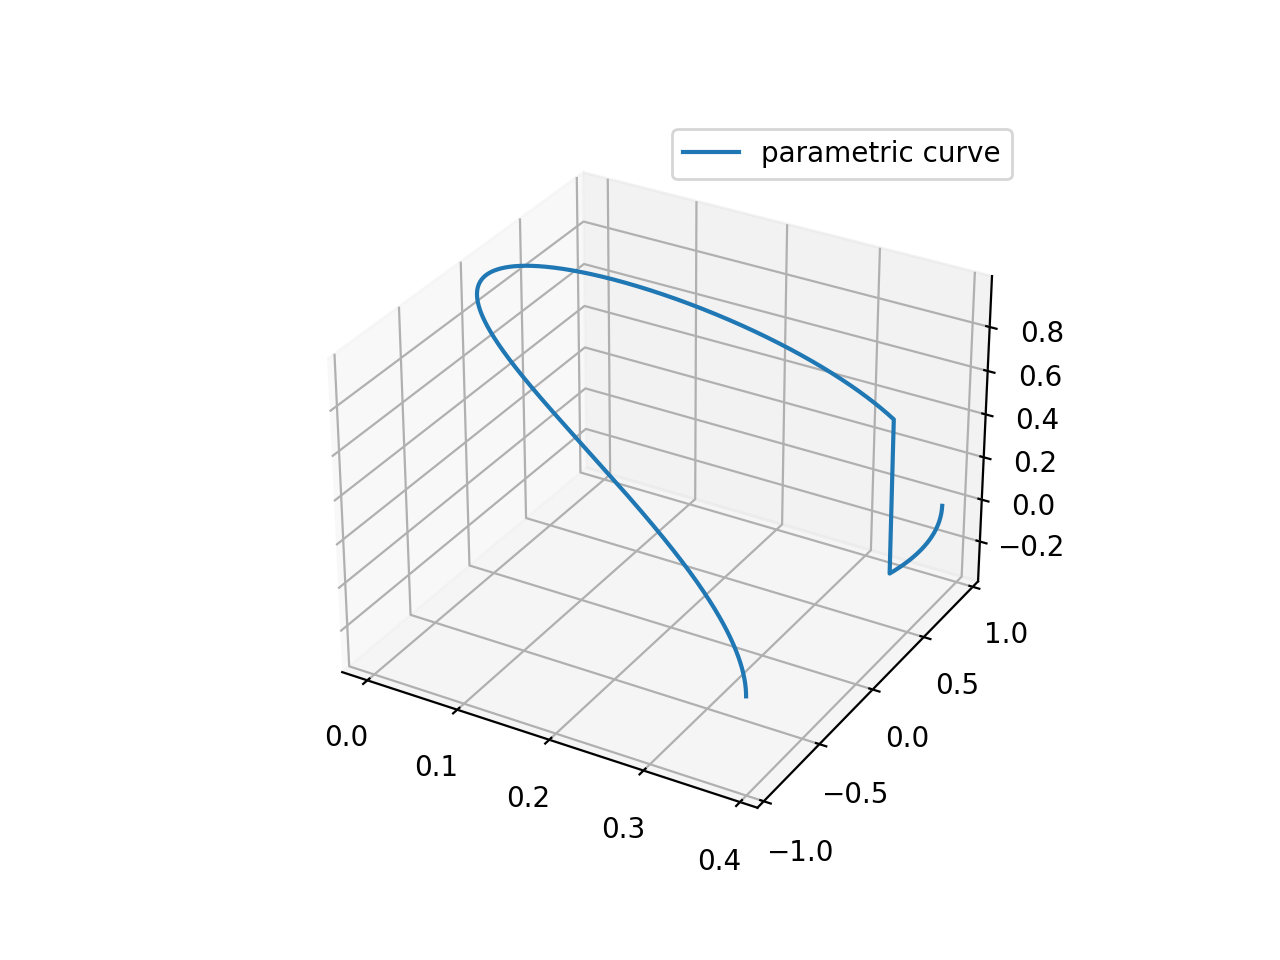

[nan  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

<ipython-input-46-8f73ff89eeed>:12: RuntimeWarning: invalid value encountered in arcsin
  phi[i] = -np.arcsin(np.tan(theta_0)/np.tan(theta[i]))
<ipython-input-46-8f73ff89eeed>:19: RuntimeWarning: invalid value encountered in arcsin
  derivative2 = nextTheta + np.arcsin(np.tan(theta_0)/np.tan(theta[i]))


In [46]:
ax = plt.figure().add_subplot(projection='3d')

f = np.linspace(-np.pi/2, np.pi/2, 1000)

theta_0 = np.pi/2.0 + 0.4

theta = np.empty(f.shape[0] - 1)
phi = np.empty(f.shape[0] - 1)

for i in range(0, f.shape[0] - 1):
    theta[i] = np.arccos(np.cos(theta_0)*np.sin(f[i]))
    phi[i] = -np.arcsin(np.tan(theta_0)/np.tan(theta[i]))
    
    derivative = np.arccos(np.cos(theta_0)*np.sin(f[i+1])) - np.arccos(np.cos(theta_0)*np.sin(f[i]))
    if derivative < 0:
        print("Switching on")
        theta[i] = -theta[i]
    nextTheta = np.arccos(np.cos(theta_0)*np.sin(f[i+1] ))
    derivative2 = nextTheta + np.arcsin(np.tan(theta_0)/np.tan(theta[i]))
    if derivative2 < 0:
        phi[i] = np.pi - phi[i]

x = np.cos(theta)*np.sin(phi)
y = np.sin(theta)*np.sin(phi)
z = np.cos(phi)

print(np.square(x) + np.square(y) + np.square(z))

ax.plot(x, y, z, label='parametric curve')
ax.legend()

plt.show()

<IPython.core.display.Javascript object>


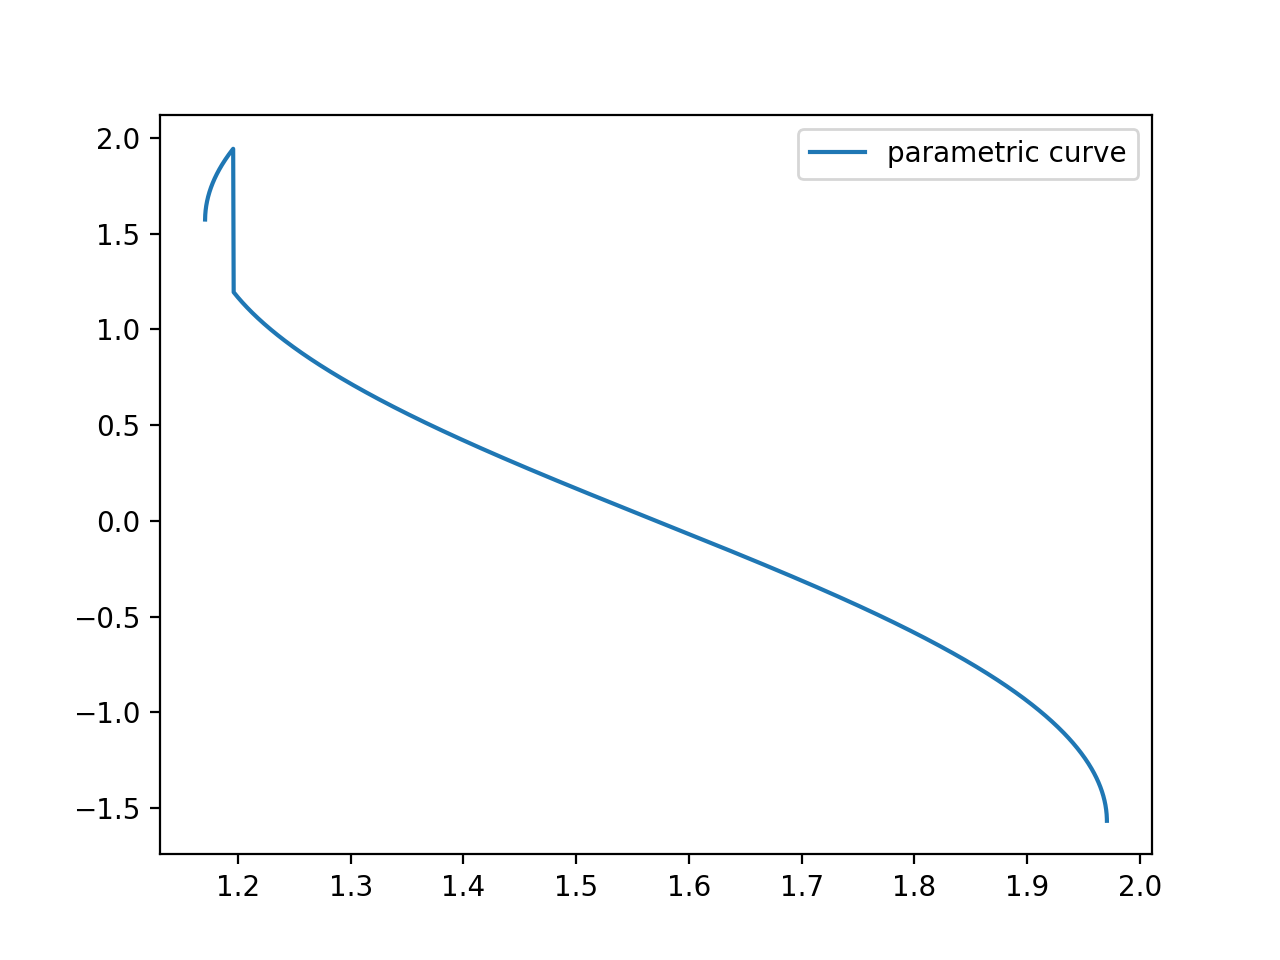

In [47]:
ax = plt.figure().add_subplot()

ax.plot(theta, phi, label='parametric curve')
ax.legend()

plt.show()